# Bring a field\'s data locally to improve performance {#ref_use_local_data_example}

Reducing the number of calls to the server is key to improving
performance. Using the `as_local_field` option brings the data from the
server to your local machine where you can work on it. When finished,
you send the updated data back to the server in one transaction.


In [1]:
# Import necessary modules
from ansys.dpf import core as dpf
from ansys.dpf.core import examples
from ansys.dpf.core import operators as ops

Create a model object to establish a connection with an example result
file and then extract:


In [2]:
model = dpf.Model(examples.download_multi_stage_cyclic_result())
print(model)
mesh = model.metadata.meshed_region

DPF Model
------------------------------
Modal analysis
Unit system: MKS: m, kg, N, s, V, A, degC
Physics Type: Mechanical
Available results:
     -  displacement: Nodal Displacement
     -  stress: ElementalNodal Stress 
     -  elastic_strain: ElementalNodal Strain
     -  structural_temperature: ElementalNodal Temperature
------------------------------
DPF  Meshed Region: 
  3595 nodes 
  1557 elements 
  Unit: m 
  With solid (3D) elements
------------------------------
DPF  Time/Freq Support: 
  Number of sets: 6 
Cumulative     Frequency (Hz) LoadStep       Substep        Harmonic index  
1              188.385357     1              1              0.000000        
2              325.126418     1              2              0.000000        
3              595.320548     1              3              0.000000        
4              638.189511     1              4              0.000000        
5              775.669703     1              5              0.000000        
6            

# Create the workflow


Compute the stress principal invariants:


In [3]:
stress_op = ops.result.stress(data_sources=model.metadata.data_sources)
stress_op.inputs.requested_location.connect(dpf.locations.nodal)
stress_op.inputs.mesh_scoping.connect(mesh.nodes.scoping)

principal_op = ops.invariant.principal_invariants_fc(stress_op)
principal_stress_1 = principal_op.outputs.fields_eig_1()[0]
principal_stress_2 = principal_op.outputs.fields_eig_2()[0]
principal_stress_3 = principal_op.outputs.fields_eig_3()[0]

# Manipulate data locally


This example goes over the fields, keeping the largest invariant value
by node if the averaged value of invariants is large enough. Exploring
data allows you to customize it to meet your needs.


In [4]:
node_scoping_ids = principal_stress_1.scoping.ids
threshold = 300000.0

field_to_keep = dpf.fields_factory.create_scalar_field(
    len(node_scoping_ids), location=dpf.locations.nodal
)

with field_to_keep.as_local_field() as f:
    with principal_stress_1.as_local_field() as s1:
        with principal_stress_2.as_local_field() as s2:
            with principal_stress_3.as_local_field() as s3:
                for i, id in enumerate(node_scoping_ids):
                    d1 = abs(s1.get_entity_data_by_id(id))
                    d2 = abs(s2.get_entity_data_by_id(id))
                    d3 = abs(s3.get_entity_data_by_id(id))
                    if (d1 + d2 + d3) / 3.0 > threshold:
                        d = max(d1, d2, d3)
                        f.append(d, id)

# Plot result field


Plot the result field on the skin mesh:


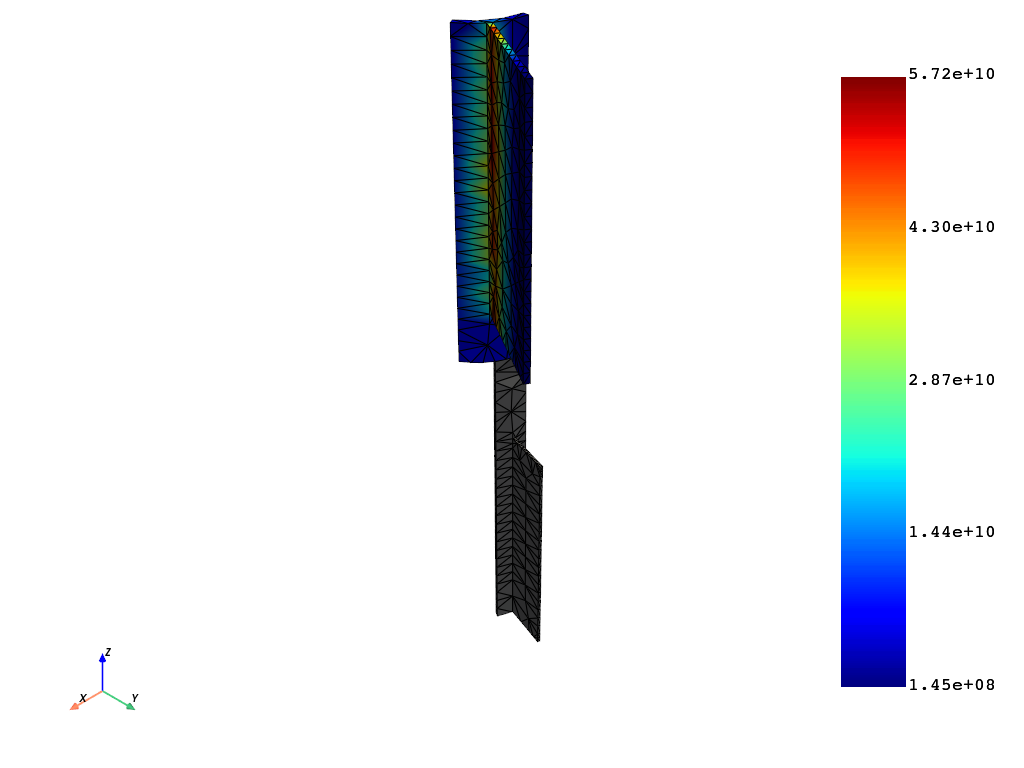

In [5]:
mesh.plot(field_to_keep)

# Plot initial invariants


Plot the initial invariants:


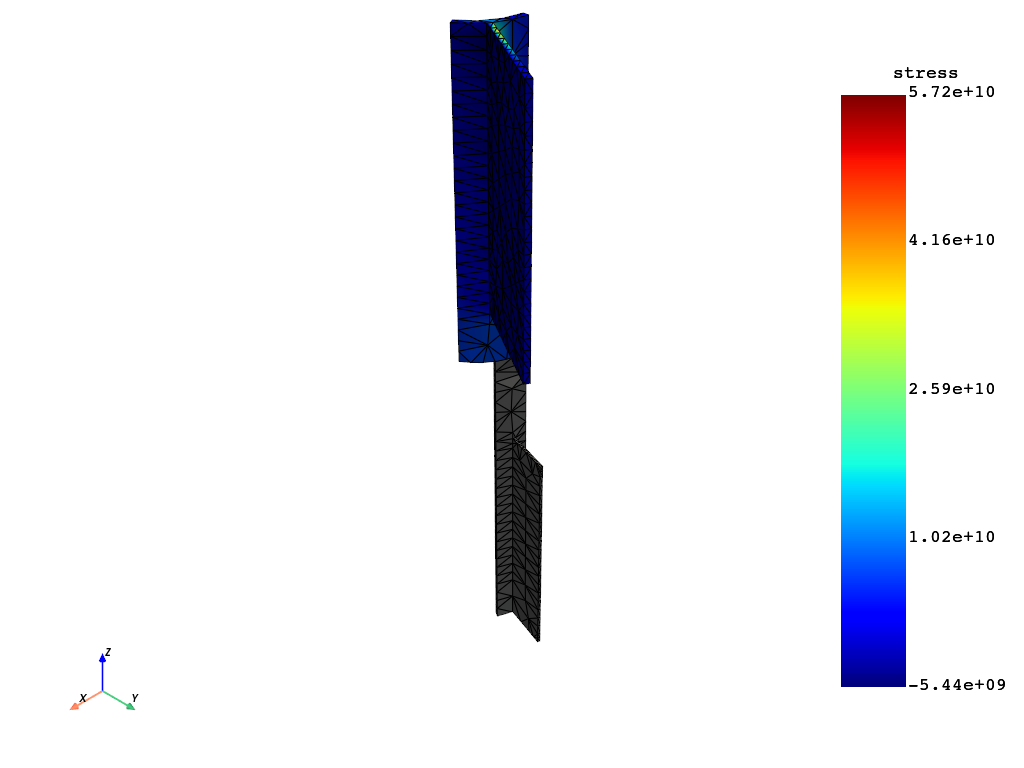

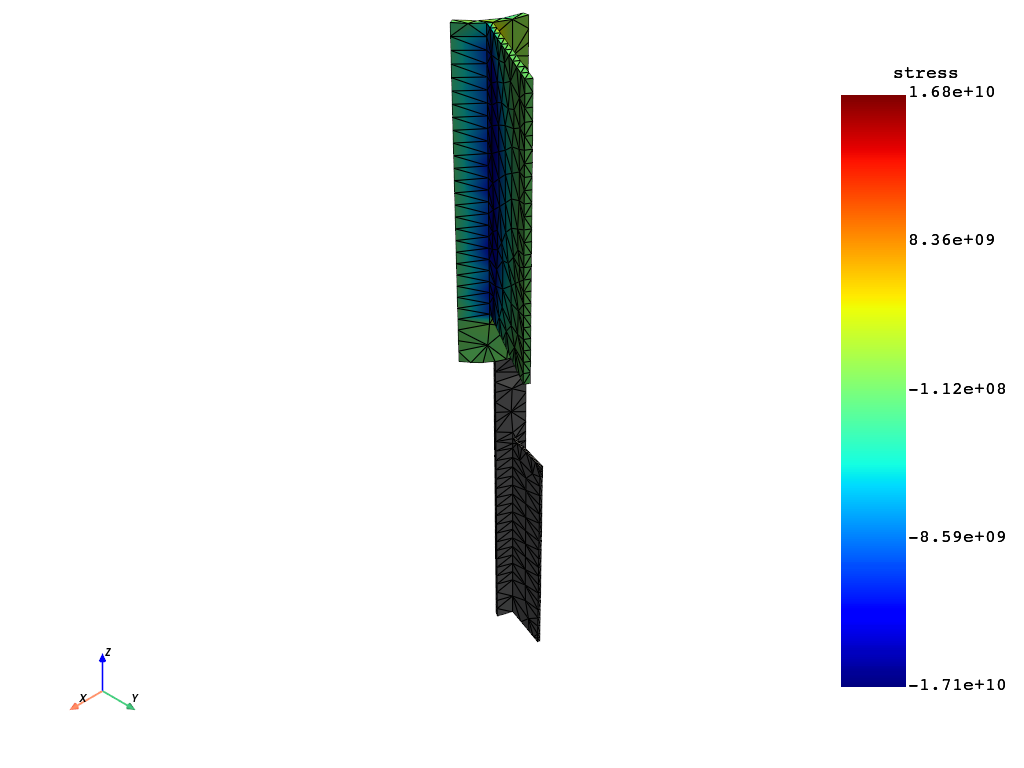

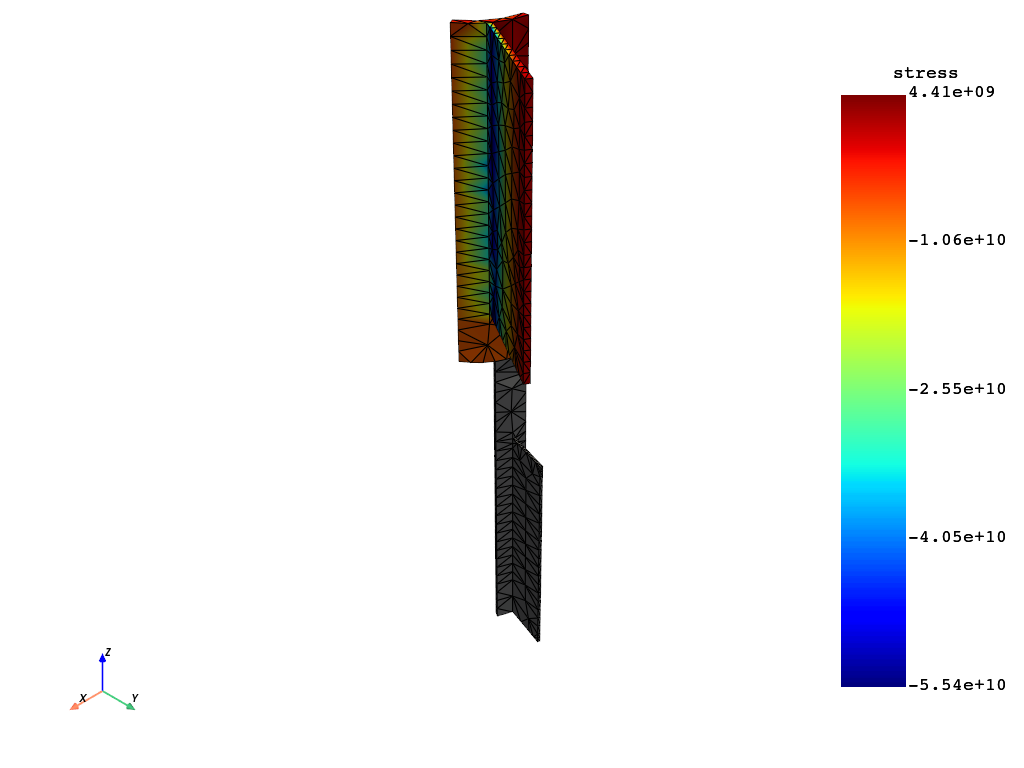

In [6]:
mesh.plot(principal_stress_1)
mesh.plot(principal_stress_2)
mesh.plot(principal_stress_3)